<a href="https://colab.research.google.com/github/Sal9779/Bootcamp_Final_Project-/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Both the FedFunds Rate & the Talyor Rule Seeing Comparisons

code and writing in two different files. Try to step back from the code and figure out what is it important and what we want to say

##Introduction to Problem & Data

###Problem Statement

Recently over the summer, I worked at an internship where I had to be very aware of the fed funds rate and any changes that may have happened. This semester, I also took Economics of Global Business, and recently, we went over the Fed's tools to control inflation. One is the effective funds rate or the rate at which banks borrow from one another. This is very important and influential as it is one of the main tools used by the Fed to control inflation, and it has a massive impact on the financial system. Altering the fed funds rate has the ability to increase or decrease the money supply in the economy as depending on the rate banks will be either incentivized to loan out money (low rate envrionment) or rather hold onto reserves (high rate environment). In that course, we also learned about the Taylor Rule, which is a strategy that helps determine at what level should the funds rate be set depending on factors such as inflation and GDP growth. This model will try to predict the future rates based of historical data in the past and use it to model what has happened previously given the situation we are in economically. I believe comparing both the fed funds rate and the Taylor rule, will be interesting to see if the models predict similar trends or if differing trends are reflected. This model will be useful and helpful to understand what rate environment the US may be entering based on historical precedent. This model will be useful for those involved in the finicial industry along with those looking for a mortgage, as these fluctuations in rates have an immense impact on the 10-year treasury, mortgage rates, and other debt instruments.

###Dataset Description

Data for this project is sourced from FRED in csv format, providing nesecassary information regarding the changes in rates and other economic indicators in the United States. The data was uploaded to a gethub and I attached the link so anyone could call the same information I pulled. The economic indicators pulled were CPI, GDP Price Deflator, Taylor Rule, GDP Growth Rate, and Potential GDP. The data will need to be attended too as it requires cleaning and formatting to be able to properly run the models in the following steps. As some of the columns have more datapoints than others, and I want to ensure they all have an equal amount. Not only that each column has an equal number of values, but also that the years and quarters involved are the same throughout. Also note that it may be difficult to model the data as there is no real trend or seasonality, as the fed funds rate and Talyor rule are dependent on other economic factors. Therefore, due to the volatility, the models may struggle to accurately predict the coming years. I hope that at least some general trend of which direction the rates are going and for how long can be agreed upon by the end.

This dataset will go from 1955 Q1 until 2024 Q1.

###Data Pre-Processing & Preliminary Examination:

In [1251]:
!pip install sktime

In [1252]:
!pip install dask[dataframe]

In [1253]:
!pip install sktime[all_extras]

In [1254]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_openml
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [1255]:
import sktime as skt
from statsmodels.graphics.tsaplots import plot_acf
from sktime.utils.plotting import plot_correlations, plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.arima import ARIMA
import pmdarima as pm

In [1432]:
#loaded in the data, from a gethub I created. All the data comes from FRED.
fed_funds_rate = pd.read_csv('https://raw.githubusercontent.com/Sal9779/stuff/refs/heads/main/FEDFUNDS%20(1).csv')
PD= pd.read_csv('https://raw.githubusercontent.com/Sal9779/stuff/refs/heads/main/GDPDEF.csv', usecols=['GDPDEF_PCH'])
real_gdp = pd.read_csv('https://raw.githubusercontent.com/Sal9779/stuff/refs/heads/main/GDPC1%20(2).csv', usecols=['GDPC1'])
potential_gdp = pd.read_csv('https://raw.githubusercontent.com/Sal9779/stuff/refs/heads/main/GDPPOT%20(1).csv', usecols=['GDPPOT'])
taylor_rule= pd.read_csv('https://raw.githubusercontent.com/Sal9779/stuff/refs/heads/main/Quarterly.csv', usecols=['GDPPOT_GDPC1_GDPDEF_PC1'])
CPI=pd.read_csv('https://raw.githubusercontent.com/Sal9779/stuff/refs/heads/main/CPIAUCSL.csv', usecols=['CPIAUCSL_PCH'])
growth_rate=pd.read_csv('https://raw.githubusercontent.com/Sal9779/stuff/refs/heads/main/GDPC1%20(3).csv', usecols=['GDPC1_PCH'])

In [1433]:
data = pd.concat([fed_funds_rate, PD, real_gdp, potential_gdp, taylor_rule, CPI, growth_rate], axis=1)#Here I am creating a dataframe with all the sources called

In [1434]:
data = data.rename(columns={'GDPPOT_GDPC1_GDPDEF_PC1': 'Talyor_Rule', 'CPIAUCSL_PCH': 'CPI', 'GDPDEF_PCH':'GDP_PD', 'GDPC1':'REAL_GDP','GDPPOT':'GDP_Ideal', 'GDPC1_PCH':'GROWTH_RATE'})#Here we are renaming all the features of the dataframe to make them easier to call

In [1435]:
data.info()#Here we see all the feature names and the number of features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         279 non-null    object 
 1   FEDFUNDS     279 non-null    float64
 2   GDP_PD       279 non-null    float64
 3   REAL_GDP     279 non-null    float64
 4   GDP_Ideal    280 non-null    float64
 5   Talyor_Rule  277 non-null    float64
 6   CPI          277 non-null    float64
 7   GROWTH_RATE  277 non-null    float64
dtypes: float64(7), object(1)
memory usage: 17.6+ KB


In [1436]:
data.head(-1)#Here we see that we have missing values for some of the features

,DATE,FEDFUNDS,GDP_PD,REAL_GDP,GDP_Ideal,Talyor_Rule,CPI,GROWTH_RATE
0,1955-01-01,1.35,0.47021,3020.746,2959.776200,3.480803,0.07471,2.85660
1,1955-04-01,1.64,0.40951,3069.910,2979.062097,4.461184,-0.29862,1.62754
2,1955-07-01,2.18,0.69915,3111.379,2998.026312,5.686245,0.52415,1.35082
3,1955-10-01,2.48,0.99082,3130.068,3017.709772,6.751882,0.07449,0.60067
4,1956-01-01,2.50,1.00258,3117.922,3037.459894,7.030162,0.07443,-0.38804
...,...,...,...,...,...,...,...,...
274,2023-07-01,5.33,0.79144,22780.933,22338.770000,6.665161,1.08058,1.07152
275,2023-10-01,5.33,0.38528,22960.600,22452.060000,5.982462,0.47317,0.78867
276,2024-01-01,5.33,0.74813,23053.545,22566.610000,5.681329,1.12975,0.40480
277,2024-04-01,5.33,0.62821,23223.906,22682.660000,NaN,NaN,NaN


In [1437]:
data = data.drop(data.index[[277, 278, 279]])#Here, we are dropping the last few rows that have missing values

In [1438]:
data.head(-1)#Here, we see that we will measure the dates 19955 Q1 to 2024 Q1

,DATE,FEDFUNDS,GDP_PD,REAL_GDP,GDP_Ideal,Talyor_Rule,CPI,GROWTH_RATE
0,1955-01-01,1.35,0.47021,3020.746,2959.776200,3.480803,0.07471,2.85660
1,1955-04-01,1.64,0.40951,3069.910,2979.062097,4.461184,-0.29862,1.62754
2,1955-07-01,2.18,0.69915,3111.379,2998.026312,5.686245,0.52415,1.35082
3,1955-10-01,2.48,0.99082,3130.068,3017.709772,6.751882,0.07449,0.60067
4,1956-01-01,2.50,1.00258,3117.922,3037.459894,7.030162,0.07443,-0.38804
...,...,...,...,...,...,...,...,...
271,2022-10-01,4.10,0.92393,22249.459,22004.679068,11.302630,0.83384,0.82783
272,2023-01-01,4.65,0.91048,22403.435,22116.380000,9.638955,0.98122,0.69204
273,2023-04-01,5.08,0.45608,22539.418,22227.570000,6.890859,0.74865,0.60697
274,2023-07-01,5.33,0.79144,22780.933,22338.770000,6.665161,1.08058,1.07152


In [1439]:
data['DATE']= pd.to_datetime(data['DATE'])#Here, we are turnig the data into a datetime

In [1440]:
data['DATE'] = pd.PeriodIndex(data['DATE'], freq='Q')#Here, we are setting the frequency to quarters

In [1441]:
data.head()

,DATE,FEDFUNDS,GDP_PD,REAL_GDP,GDP_Ideal,Talyor_Rule,CPI,GROWTH_RATE
0,1955Q1,1.35,0.47021,3020.746,2959.776200,3.480803,0.07471,2.85660
1,1955Q2,1.64,0.40951,3069.910,2979.062097,4.461184,-0.29862,1.62754
2,1955Q3,2.18,0.69915,3111.379,2998.026312,5.686245,0.52415,1.35082
3,1955Q4,2.48,0.99082,3130.068,3017.709772,6.751882,0.07449,0.60067
4,1956Q1,2.50,1.00258,3117.922,3037.459894,7.030162,0.07443,-0.38804


In [1442]:
data.head(-1)

,DATE,FEDFUNDS,GDP_PD,REAL_GDP,GDP_Ideal,Talyor_Rule,CPI,GROWTH_RATE
0,1955Q1,1.35,0.47021,3020.746,2959.776200,3.480803,0.07471,2.85660
1,1955Q2,1.64,0.40951,3069.910,2979.062097,4.461184,-0.29862,1.62754
2,1955Q3,2.18,0.69915,3111.379,2998.026312,5.686245,0.52415,1.35082
3,1955Q4,2.48,0.99082,3130.068,3017.709772,6.751882,0.07449,0.60067
4,1956Q1,2.50,1.00258,3117.922,3037.459894,7.030162,0.07443,-0.38804
...,...,...,...,...,...,...,...,...
271,2022Q4,4.10,0.92393,22249.459,22004.679068,11.302630,0.83384,0.82783
272,2023Q1,4.65,0.91048,22403.435,22116.380000,9.638955,0.98122,0.69204
273,2023Q2,5.08,0.45608,22539.418,22227.570000,6.890859,0.74865,0.60697
274,2023Q3,5.33,0.79144,22780.933,22338.770000,6.665161,1.08058,1.07152


In [1443]:
data.set_index('DATE', inplace=True)#Here, we are setting the date as the index

In [1444]:
data.head()

,FEDFUNDS,GDP_PD,REAL_GDP,GDP_Ideal,Talyor_Rule,CPI,GROWTH_RATE
DATE,,,,,,,
1955Q1,1.35,0.47021,3020.746,2959.776200,3.480803,0.07471,2.85660
1955Q2,1.64,0.40951,3069.910,2979.062097,4.461184,-0.29862,1.62754
1955Q3,2.18,0.69915,3111.379,2998.026312,5.686245,0.52415,1.35082
1955Q4,2.48,0.99082,3130.068,3017.709772,6.751882,0.07449,0.60067
1956Q1,2.50,1.00258,3117.922,3037.459894,7.030162,0.07443,-0.38804


In [1445]:
data= data.sort_index()#Here we are setting the index to be sorted by the year and quarter

In [1446]:
data.head(-1)#Ensuring that only 1955Q1-2024 Q1

,FEDFUNDS,GDP_PD,REAL_GDP,GDP_Ideal,Talyor_Rule,CPI,GROWTH_RATE
DATE,,,,,,,
1955Q1,1.35,0.47021,3020.746,2959.776200,3.480803,0.07471,2.85660
1955Q2,1.64,0.40951,3069.910,2979.062097,4.461184,-0.29862,1.62754
1955Q3,2.18,0.69915,3111.379,2998.026312,5.686245,0.52415,1.35082
1955Q4,2.48,0.99082,3130.068,3017.709772,6.751882,0.07449,0.60067
1956Q1,2.50,1.00258,3117.922,3037.459894,7.030162,0.07443,-0.38804
...,...,...,...,...,...,...,...
2022Q4,4.10,0.92393,22249.459,22004.679068,11.302630,0.83384,0.82783
2023Q1,4.65,0.91048,22403.435,22116.380000,9.638955,0.98122,0.69204
2023Q2,5.08,0.45608,22539.418,22227.570000,6.890859,0.74865,0.60697


The updated dataset that I will be working on contains all the information for the next models.

###Interest Rate Markov regression

In [1447]:
import seaborn as sns

Text(0.5, 1.0, 'Distribution of Fed Funds Rate')

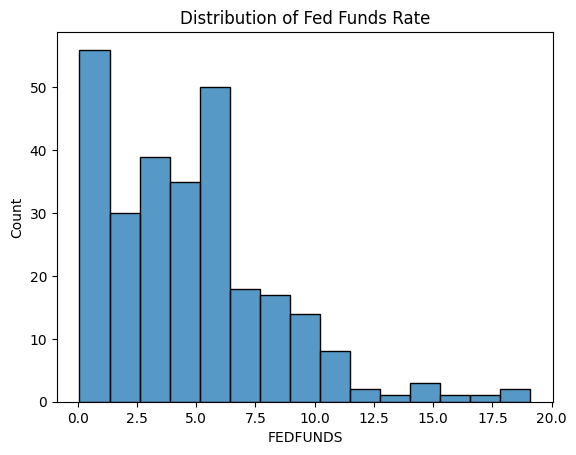

In [1738]:
#histogram of scores
sns.histplot(data = data, x = 'FEDFUNDS')
plt.title('Distribution of Fed Funds Rate')

Here, we see that the data is right-skewed, meaning that the lower interest rates make up more of the Fed's policy than higher rates. This will be interesting compared to Markov's regression later in this report, particularly the differing interest rate regimes and how they compare to the given histogram.

In [1449]:
data['FEDFUNDS'].mean()

4.641046931407942

Here, we see the mean effective funds rate in the US since 1955.




In [1274]:
data['FEDFUNDS'].median()

4.32

Here, we see the median effective funds rate in the US since 1955.

In [1275]:
data['FEDFUNDS'].max()

19.1

Here, we see the max fed funds rate.

In [1276]:
data['FEDFUNDS'].min()

0.07

This was the lowest interest rate set by the fed.

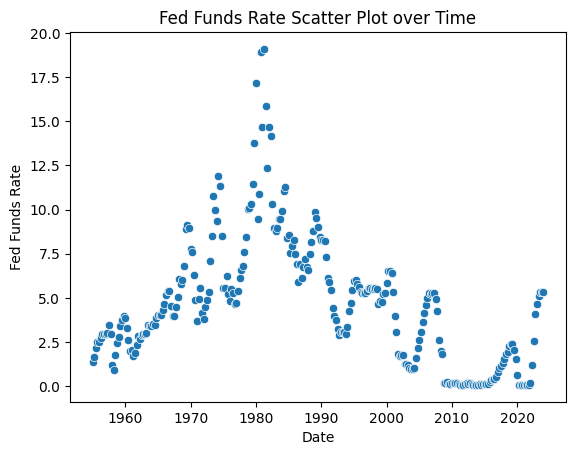

In [1425]:
sns.scatterplot(data=data.reset_index(), x='DATE', y='FEDFUNDS')
plt.title('Fed Funds Rate Scatter Plot over Time')
plt.xlabel('Date')
plt.ylabel('Fed Funds Rate')
plt.show()

In the following scatter plot we see somewhat of a general trend in rates they typically decrease after high rate peaks. Therefore, we shall see if models are able to predict and learn from the trends demonstrated here. Overall in the scatterplot, we see varying peaks and valleys overtime reflecting high and low interest rate environments. More recently we have seem a shift, however toward lower rates at least compared to the 1980s and 90s.

In the following section, we will dive into Markov's regression model and examine what sort of regimes the rates fall under. Not only will we be classifying the inerest rate regime, we also will be able to exam the duration of the periods of each.

In [1427]:
from statsmodels.tsa.regime_switching.tests.test_markov_regression import fedfunds
import statsmodels.api as sm

In [1428]:
mod_fedfunds = sm.tsa.MarkovRegression(data['FEDFUNDS'], k_regimes=2)
res_fedfunds = mod_fedfunds.fit()

Here, I decided to pick two regimes to reflect a level of high and low interest rates, and sorting the values accordingly.

In [1279]:
res_fedfunds.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  277
Model:               MarkovRegression   Log Likelihood                -646.505
Date:                Fri, 13 Dec 2024   AIC                           1303.010
Time:                        01:32:19   BIC                           1321.130
Sample:                    03-31-1955   HQIC                          1310.281
                         - 03-31-2024                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2731      0.219     10.402      0.000       1.845       2.701
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6889      0.259     29.737      0.000       7.182       8.196
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.6288      0.486     11.581      0.000       4.676       6.581
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9877      0.009    109.093      0.000       0.970       1.005
p[1->0]        0.0207      0.013      1.591      0.112      -0.005       0.046
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<Axes: title={'center': 'Probability of being in the high regime'}, xlabel='DATE'>

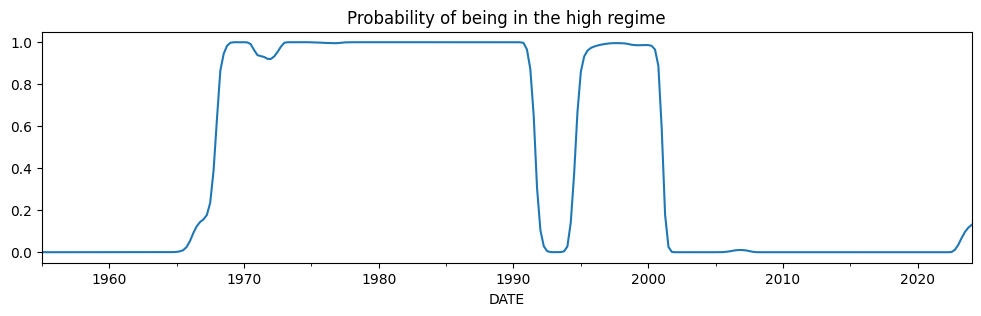

In [1280]:
res_fedfunds.smoothed_marginal_probabilities[1].plot(
    title="Probability of being in the high regime", figsize=(12, 3)
)

Here we see a graph of the different interest rate regimes according to the Markov regression statistics.

In [1281]:
print(res_fedfunds.expected_durations)

[81.15152537 48.19996908]


This reflects the interest rate regime time frame for each rate, whether a high or low regime. Here, we see the high interest rate regimes in the last 81 quarters compared to 48 low interest rate regimes. Therefore, this demonstrates the period in which either regime was dominant compared to the other and the duration of said period in quarters.

In [1450]:
mod_fedfunds2 = sm.tsa.MarkovRegression(
    data["FEDFUNDS"].iloc[1:], k_regimes=3, exog=data["FEDFUNDS"].iloc[:-1]
)
res_fedfunds2 = mod_fedfunds2.fit()

In [1451]:
res_fedfunds2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  276
Model:               MarkovRegression   Log Likelihood                -325.511
Date:                Fri, 13 Dec 2024   AIC                            677.022
Time:                        02:02:14   BIC                            724.087
Sample:                    06-30-1955   HQIC                           695.909
                         - 03-31-2024                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1275      0.236      0.540      0.589      -0.335       0.590
x1             0.7367      0.022     32.962      0.000       0.693       0.780
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1414      0.084      1.688      0.091      -0.023       0.306
x1             0.9818      0.016     62.949      0.000       0.951       1.012
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3443      0.375     -0.919      0.358      -1.079       0.390
x1             1.3148      0.039     33.416      0.000       1.238       1.392
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3978      0.040      9.827      0.000       0.318       0.477
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.4855      0.153      3.174      0.002       0.186       0.785
p[1->0]        0.0466      0.021      2.256      0.024       0.006       0.087
p[2->0]        0.2321      0.122      1.903      0.057      -0.007       0.471
p[0->1]        0.2935      0.143      2.053      0.040       0.013       0.574
p[1->1]        0.9223      0.028     33.372      0.000       0.868       0.976
p[2->1]        0.4039      0.156      2.582      0.010       0.097       0.710
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<Axes: title={'center': 'Smoothed probability of a high-interest rate regime'}, xlabel='DATE'>

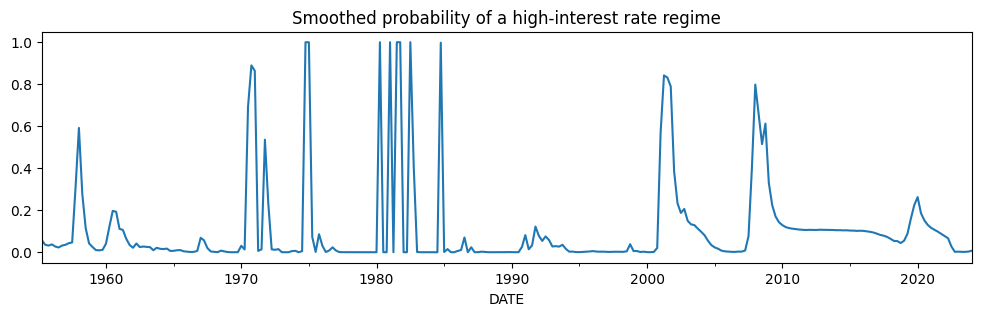

In [1452]:
res_fedfunds2.smoothed_marginal_probabilities[0].plot(
    title="Smoothed probability of a high-interest rate regime", figsize=(12, 3)
)

Here, we see the high interest rate regime graph and the probability of said interest rate regime.

Interestingly, we see that over the 1970s-1980s we see massive peaks in sequence for the most part on after another. This makes sense as over this period the US was fighting stagflation and in response, the fed at the time decided to tackle inflation. However, more recently we see almost no peaks other than before recession and in the most recent example after the covid crisis.

In [1453]:
print(res_fedfunds2.expected_durations)

[ 1.94354615 12.86990975  1.57230878]


Here, we measured three different regimes and the durations for each. High, Middle, and Low.

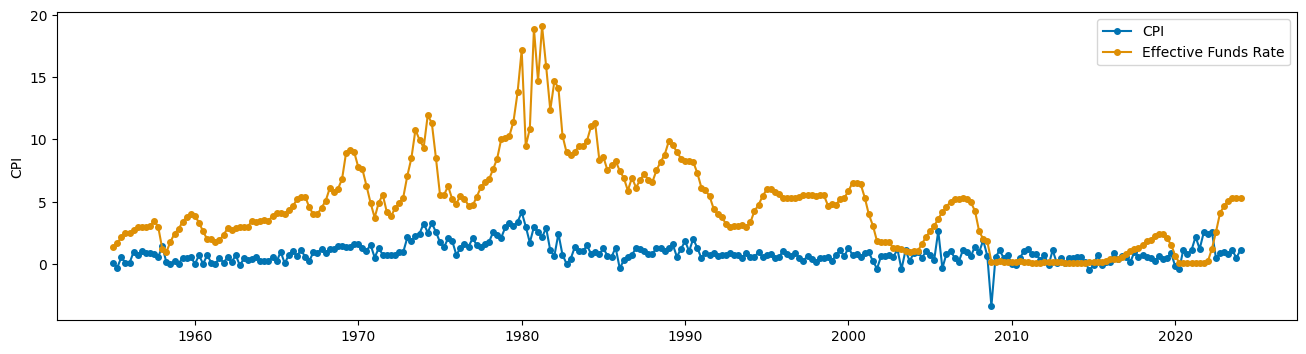

In [1733]:
plot_series(data['CPI'], data['FEDFUNDS'], labels=['CPI', 'Effective Funds Rate']);

In this graph here, we are examining the impact the Fed funds rate has on inflation, as setting interest rates is one of the Fed's main tools to control inflation by altering the money supply in the economy for the country. Generally, we see when rates are higher, inflation typically decreases, as seen in the 1980s, for example. However, we see a deviation from this in 2000s-2010 as a response to the financial crisis as we see rates follow a decline in inflation. This was most likely due to the Fed being late in lowering rates leading up to the 2008 financial crisis. More recently after the pandemic we see a clear trend of the Fed increasing rates following a stint of inflation. This delayed response was most likely due to the recovery from the pandemic and already unstable economic prospects at the time. The Fed was also unsure if the inflation during that time frame was going to stick or if it was transitory due to the massive shock caused by the pandemic world wide.

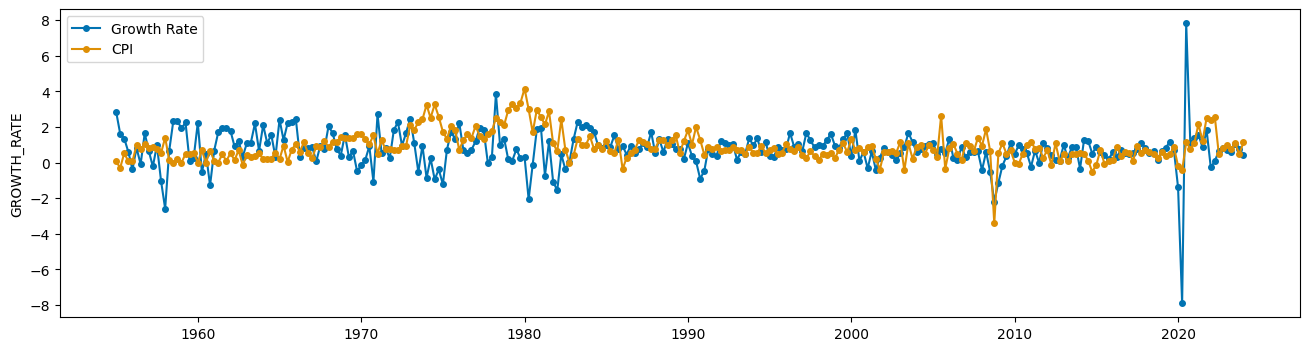

In [1734]:
plot_series(data['GROWTH_RATE'], data['CPI'], labels=['Growth Rate', 'CPI']);

Here we see while in lower rate regimes we typically see higher economic or GDP output compared to when rates are at higher levels. For example when rates were very high in the 1970s-1980s we see an overall decline in economic output than when we are in lower rate eras. More recently, we see lower volatility when compared to previous years in terms of both growth rate and inflation. Although more recently we have seen sharp inclines and declines in each due to the covid pandemic that caused very low levels of output and inflation, followed by high levels of economic growth and then high inflation. We also interestingly see massive growth in the 1960s compared to the level of inflation for the period.

##Effective Funds Rate

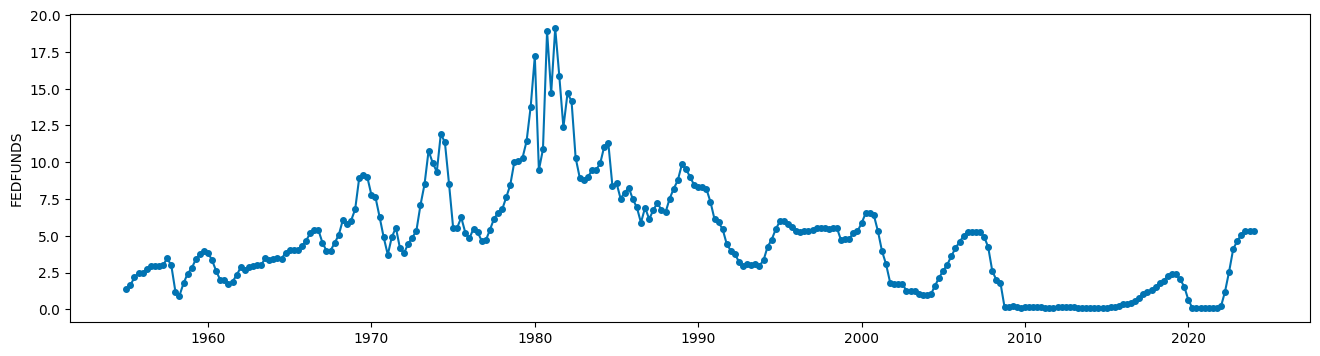

In [1286]:
plot_series(data['FEDFUNDS']);

Here we are mapping the entire effective fund's rate from 1955 Q1 to 2024 Q1.

<Axes: >

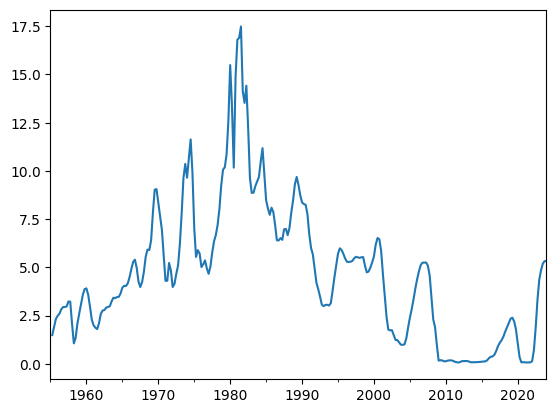

In [1287]:
data['FEDFUNDS'].rolling(2).mean().plot()

In [1288]:
X_train, X_test = temporal_train_test_split(data['FEDFUNDS'], test_size=0.1)

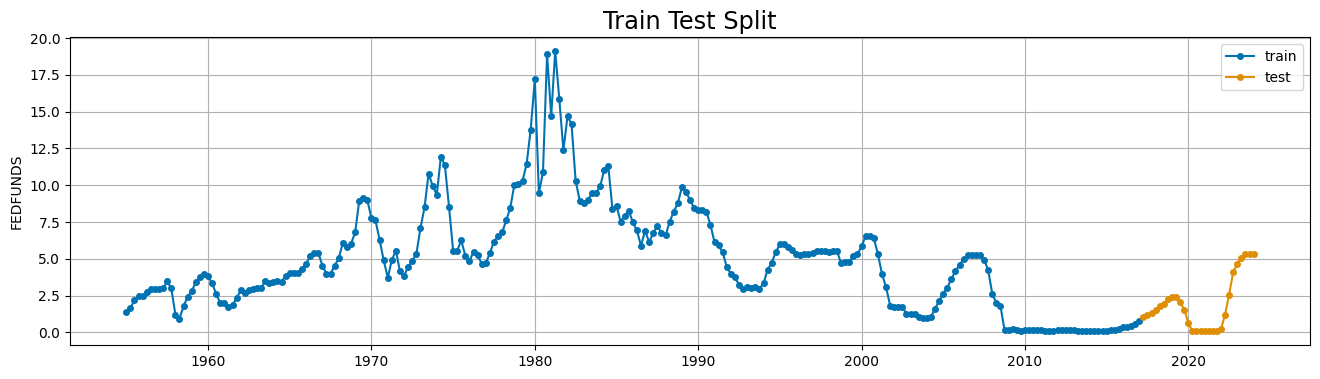

In [1289]:
plot_series(X_train, X_test, labels = ['train', 'test'], title = 'Train Test Split')
plt.grid();

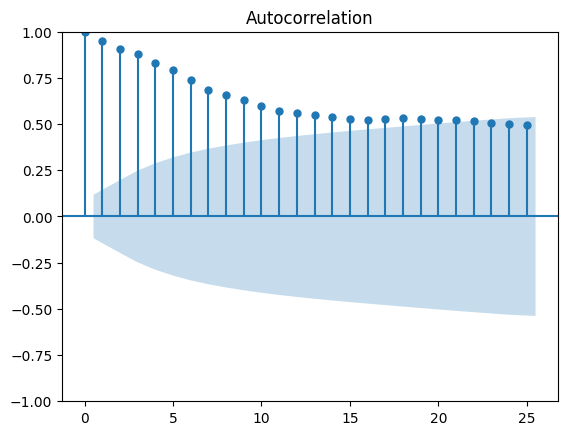

In [1290]:
plot_acf(data['FEDFUNDS'])
plt.show()

Here, we see a general trend of rates decreasing over time. This represents that the effective funds rate is correlated to itself, as all the values are somewhat correlated to the first value.

In [1291]:
fedfunds_diff=data['FEDFUNDS'].diff()

<Axes: >

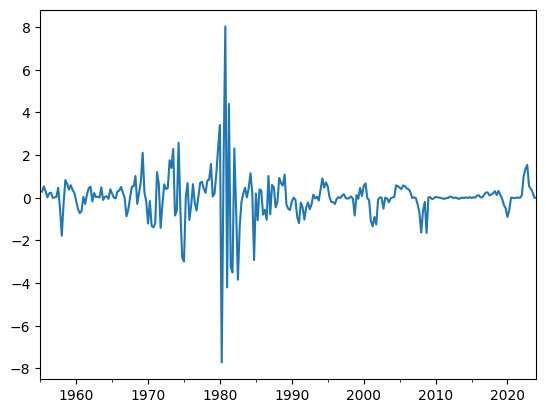

In [1292]:
fedfunds_diff.plot()

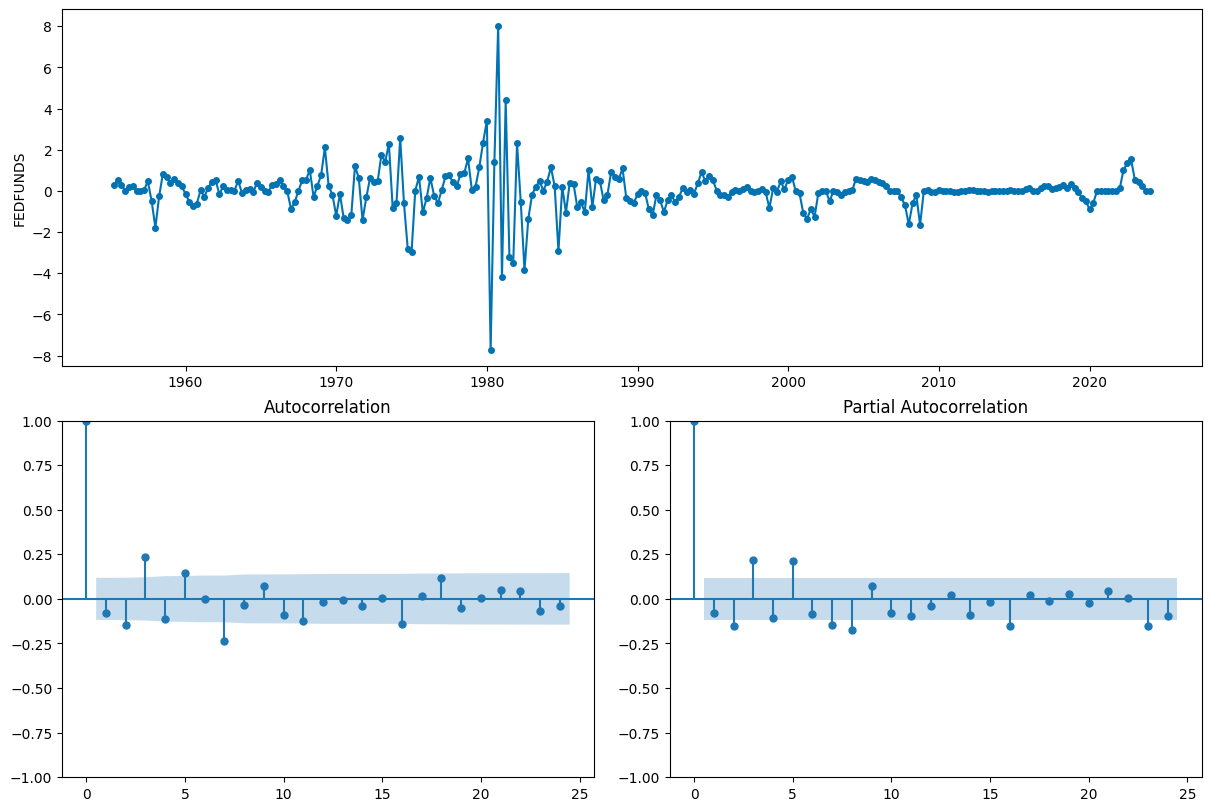

In [1293]:
plot_correlations(data['FEDFUNDS'].diff(1).dropna());

Now after differencing the data the data is no longer correlated and that we removed the trend.

In [1294]:
y= data['FEDFUNDS']

In [1295]:
y.head()

,FEDFUNDS
1955Q1,1.35
1955Q2,1.64
1955Q3,2.18
1955Q4,2.48
1956Q1,2.50


###Fed Funds Rate Naive Model

Here we will create a naive forecast using the last value as our baseline model. Therefore, any subsequent models that we use will have to perform than if the fed made no change to rates at all. As we know in relative the fed has already cut rates at this period, but that will not be included.

In [1296]:
from sktime.forecasting.naive import NaiveForecaster
nf = NaiveForecaster(strategy="last")
nf.fit(X_train)

NaiveForecaster()

In [1297]:
fh = np.arange(len(X_test))

In [1298]:
len(X_test)

28

In [1299]:
exp_preds = nf.predict(fh)

In [1300]:
mae = MeanAbsolutePercentageError()
mae(X_test, exp_preds)

/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:645: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


2.732196140513685

Here we see that the naive forecast is not at all in anyways able to predict the test data. This is shown by its 273% mean absolute error percentage.

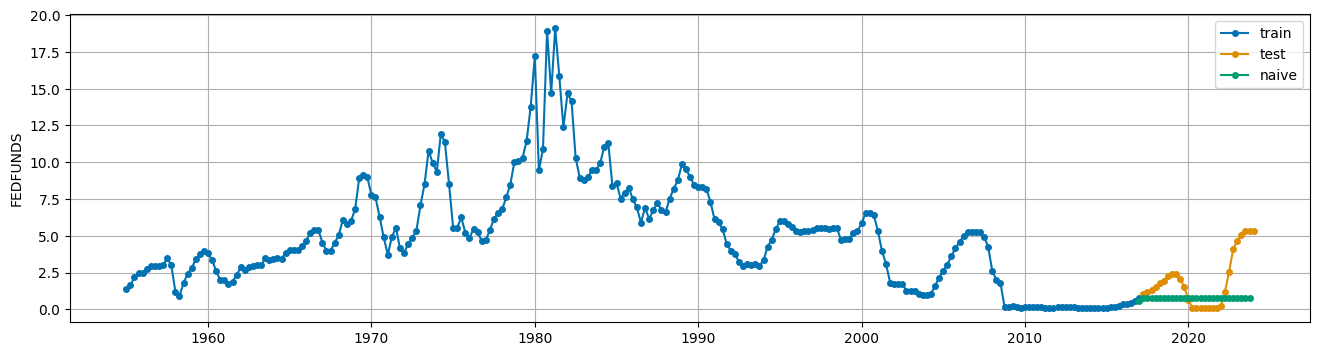

In [1301]:
plot_series(X_train, X_test, exp_preds,
            labels = ['train','test','naive'],
           )
plt.grid();

In [1302]:
forecaster = NaiveForecaster(strategy="last")

In [1303]:
forecaster.fit(y)

NaiveForecaster()

In [1304]:
y_hat = forecaster.predict( fh = [i for i in range(0, 16)])

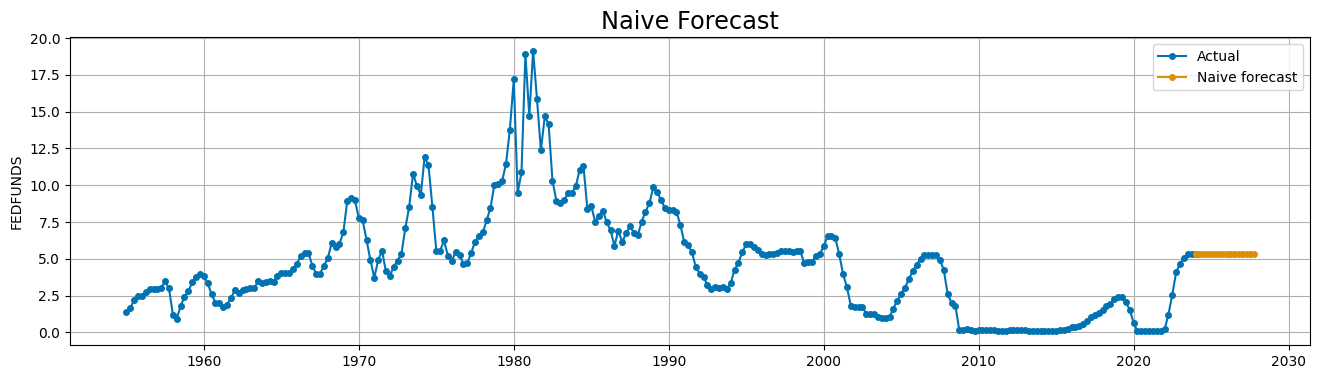

In [1305]:
plot_series(y, y_hat,
            labels=['Actual','Naive forecast'],
            title='Naive Forecast')
plt.grid();
plt.savefig('naive_forecast.png')

This here is our base mdoel, which reflects that the naive forecast will predict that the last rate will last for the for see able future and will not change. We will compare our future models to this to see how accurate our following models will be.

###Fed Funds Holt-Winters Model

The Holt-Winters model is an extension of the exponential smoothing model, by taking into account seasonality, trend, and steps. Here we choose 10 steps as it lowered the mae to the lowest level. I also decided to make the trend additive as it generally follows a general downward trend recently as shown in the scatterplot, but for the seasonal parameter I decided to classify it as multiplicative as the seasons themselves vary in size depending on the regime as exemplified in the 1970s-1980s compared to more recent times.

In [1624]:
hw= ExponentialSmoothing(sp=10,trend='add', seasonal='mul')

In [1625]:
hw.fit(X_train)

ExponentialSmoothing(seasonal='mul', sp=10, trend='add')

In [1626]:
fh= np.arange(len(X_test))

In [1627]:
hw_predicts= hw.predict(fh)

In [1628]:
mae = MeanAbsolutePercentageError()
mae(X_test, hw_predicts)

/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:645: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


2.8774035739101995

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='FEDFUNDS'>)

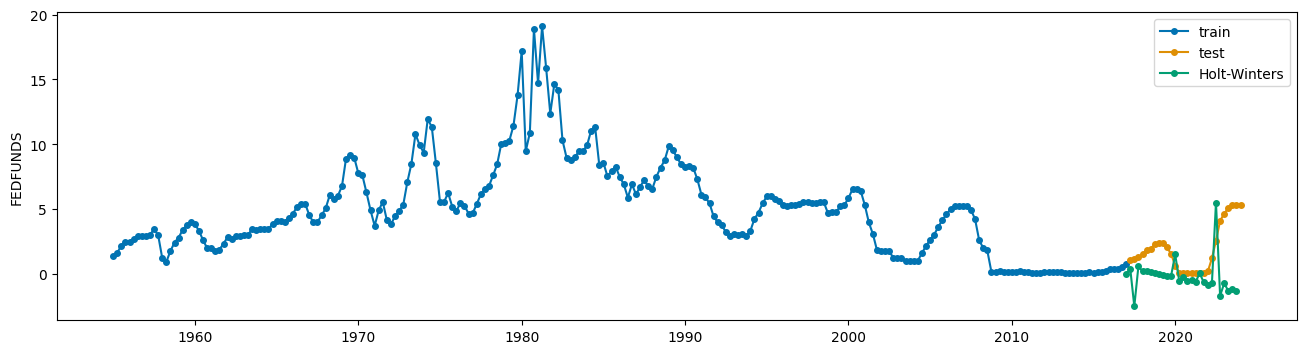

In [1629]:
plot_series(X_train, X_test, hw_predicts,
            labels = ['train', 'test','Holt-Winters'],
             )

In [1531]:
hw.fit(y)

ExponentialSmoothing(seasonal='mul', sp=10, trend='add')

In [1532]:
y_hw = hw.predict( fh = [i for i in range(0, 16)])

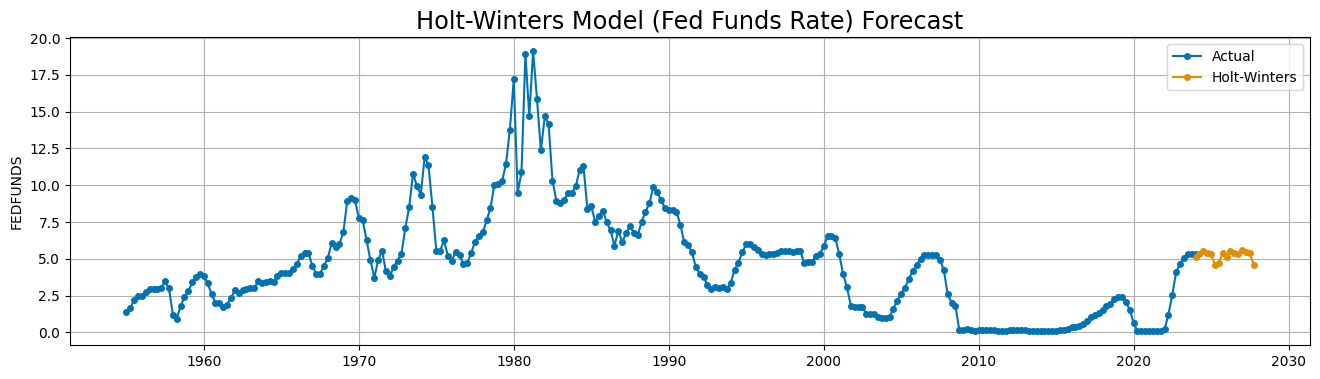

In [1533]:
plot_series(y, y_hw,
            labels=['Actual','Holt-Winters'],
            title='Holt-Winters Model (Fed Funds Rate) Forecast')
plt.grid();
plt.savefig('naive_forecast.png')

In this graph here we see that the holt-winters model predicts a downward trend in the coming quarters, although it goes back up and then back down. It possibly is over simplifying the trends. This can be proven to be somewhat correct as the mae is very high and worse than the baseline model. It seems the model is unable to predict more gradual trends.  

###Fed Funds ARIMA Model

In [1609]:
auto_model = pm.auto_arima(X_train,
                          seasonal=True, m=7,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=False)

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=785.781, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=772.097, Time=0.44 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=774.025, Time=0.74 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=773.908, Time=0.10 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=774.044, Time=0.21 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=775.901, Time=0.45 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=773.564, Time=0.19 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=775.539, Time=0.47 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=777.321, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=784.343, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=769.183, Time=0.16 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=771.077, Time=0.27 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=771.404, Time=0.12 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=771.104, Time=0.25 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=772.923, Time=0.65 sec
 ARIMA(0,1,1)(2,0,0)[7] i

In [1610]:
arima= ARIMA(order=(1,1,3), seasonal_order=(0,0,1,7))

In [1612]:
arima.fit(X_train)

ARIMA(order=(1, 1, 3), seasonal_order=(0, 0, 1, 7))

In [1613]:
fh= np.arange(len(X_test))

In [1614]:
arima_preds = arima.predict(fh)

In [1615]:
mae(X_test, arima_preds)

/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:645: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


1.8811905860121807

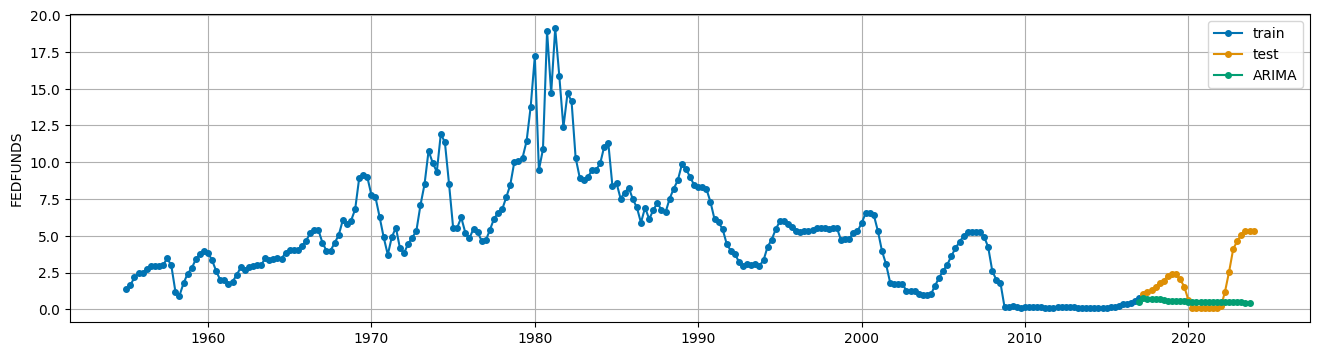

In [1616]:
plot_series(X_train, X_test, arima_preds,
            labels = ['train', 'test','ARIMA'],
           )
plt.grid();

In [1617]:
arima.fit(y)

ARIMA(order=(1, 1, 3), seasonal_order=(0, 0, 1, 7))

In [1636]:
fh= np.arange(0, 16)

In [1637]:
y_arima= arima.predict(fh)

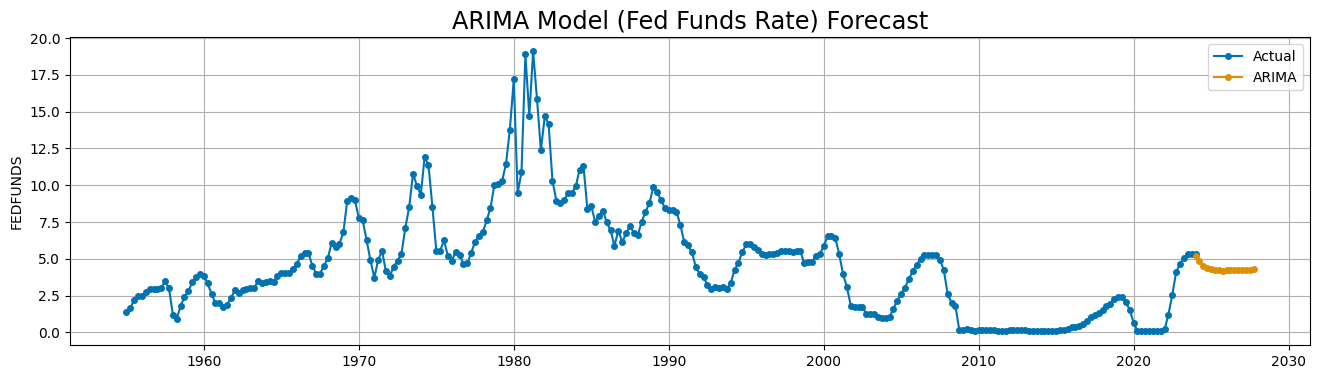

In [1638]:
plot_series(y, y_arima,
            labels = ['Actual','ARIMA'],
             title='ARIMA Model (Fed Funds Rate) Forecast')
plt.grid();

Here we see our best model yet outperforming our baseline. Although it is interesting how the model initially is able to predict a downward shift in rates in the coming quarters or fed meetings, but after a certain point it sseems that the model beleives the fed will hold rates after. Maybe here the model is too gradual.

###Fed Funds Prophet Model

In [1645]:
prophet= Prophet(seasonality_mode='additive', n_changepoints=int(len(X_train)))

In [1646]:
prophet.fit(X_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 198.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchdf5ucg/9jh4q9mr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchdf5ucg/gz37e51n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94843', 'data', 'file=/tmp/tmpchdf5ucg/9jh4q9mr.json', 'init=/tmp/tmpchdf5ucg/gz37e51n.json', 'output', 'file=/tmp/tmpchdf5ucg/prophet_modelgrcec1br/prophet_model-20241213025601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:56:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:56:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Prophet(n_changepoints=249)

In [1647]:
fh = np.arange(len(X_test))

In [1648]:
prophet_preds = prophet.predict(fh)

In [1649]:
mae = MeanAbsolutePercentageError()
mae(X_test, prophet_preds)

/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:645: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


6.752474100107571

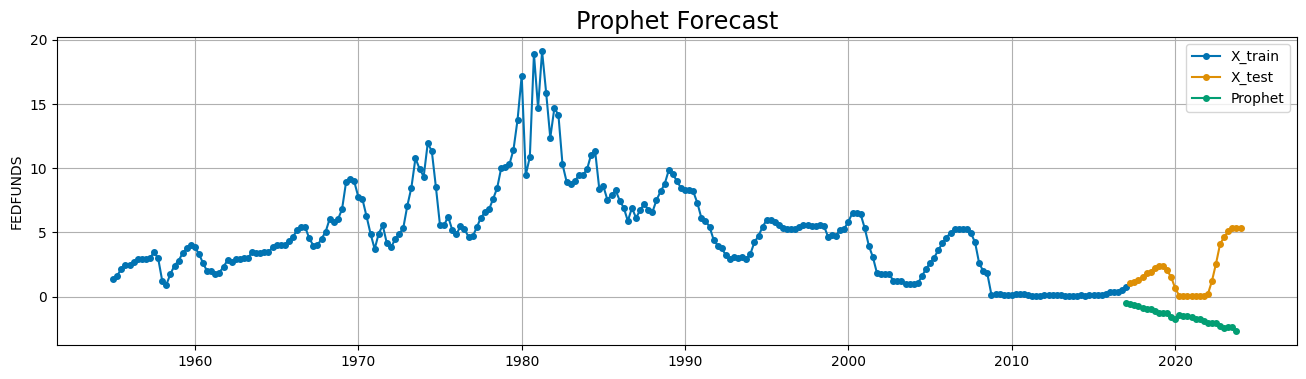

In [1650]:
plot_series(X_train, X_test, prophet_preds,
            labels=['X_train','X_test', 'Prophet'],
            title='Prophet Forecast')
plt.grid();

In [1651]:
prophet.fit(y)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 220.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchdf5ucg/3zni_tx9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchdf5ucg/rfmcxxf8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79720', 'data', 'file=/tmp/tmpchdf5ucg/3zni_tx9.json', 'init=/tmp/tmpchdf5ucg/rfmcxxf8.json', 'output', 'file=/tmp/tmpchdf5ucg/prophet_modelz43jluxn/prophet_model-20241213025609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:56:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:56:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Prophet(n_changepoints=249)

In [1652]:
fh= np.arange(0, 16)

In [1653]:
y_pred= prophet.predict(fh)

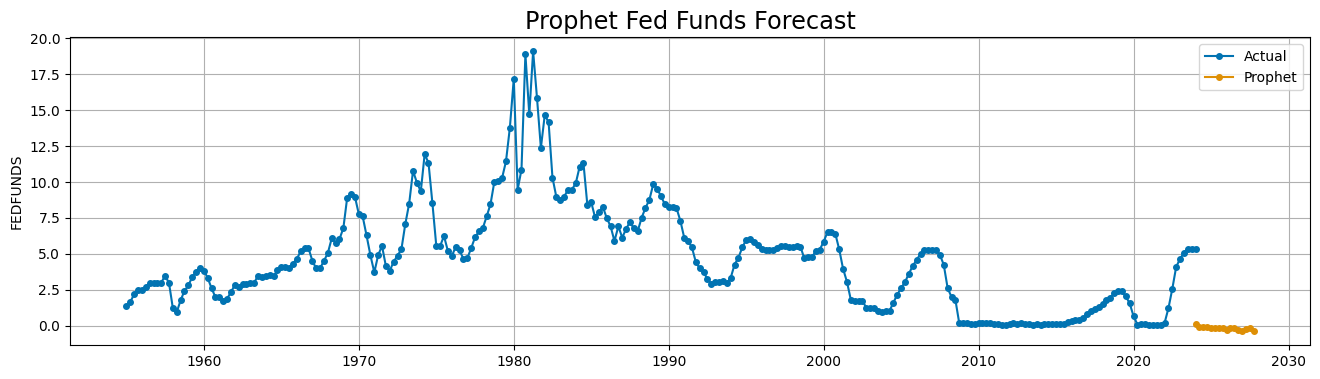

In [1654]:
plot_series(y, y_pred,
            labels=['Actual','Prophet'],
            title='Prophet Fed Funds Forecast')
plt.grid();

All the previous models were models we tested in class. I thought it would be interesting to incorporate an outside model that I found while searching in hugging face. The model that made the most sense I thought was facebook's prophet model, due to its easy use and its ability to pick up trends and apply them well. Although it is important to note that the prophet model is typically used for more directly seasonal targets such as modeling ahead of holidays. Here, we see that the model heavily underperforms all the other models and its mae was absolutely worse than our baseline, meaning it is not a model that could be used to predict future fed funds rates.

##Fed Funds Overall All Models

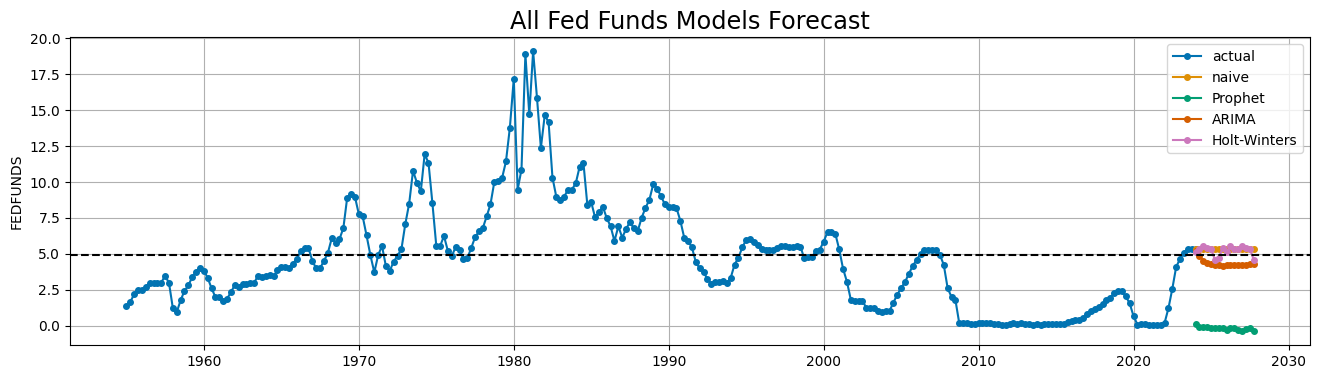

In [1655]:
plot_series(y, y_hat, y_pred, y_arima, y_hw,
            labels = ['actual', 'naive', 'Prophet','ARIMA','Holt-Winters'],
             title='All Fed Funds Models Forecast')

plt.axhline(y=data_mean, color='black', linestyle='--', label='Mean')
plt.grid();

Here we see all the models reflected and also added the mean line of all the rates. Overall, the best performing model was the arima model and it predicts a downward trend in the coming quarters although it flattens out. All the other models did not really out perform the baseline. Even then the arima model slightly outperformed the baseline when examining the train and test variables of the data.

##Taylor Rule

Now will be examining the same models but now in comparison to the Taylor rule to see if there is any overlap in the direction of the predictive models for the future.

In [1656]:
z= data['Talyor_Rule']

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Talyor_Rule'>)

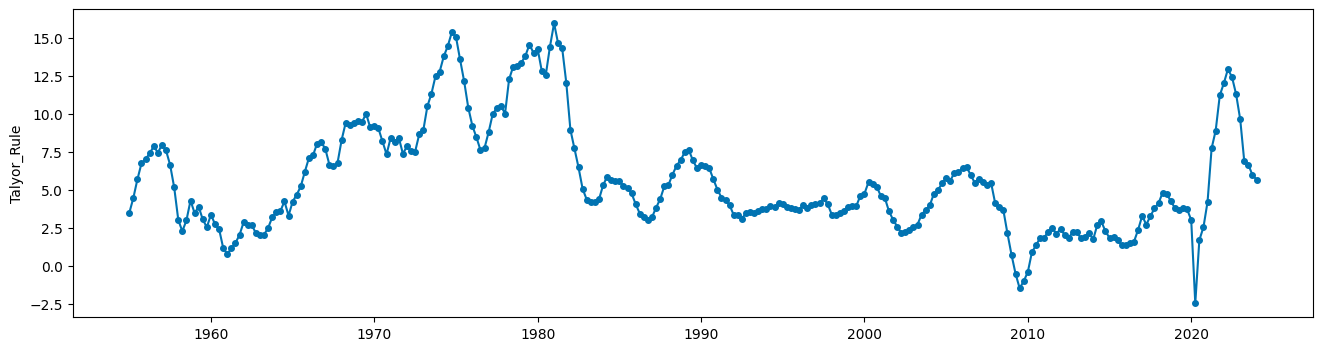

In [1657]:
plot_series(data['Talyor_Rule'])

<Axes: >

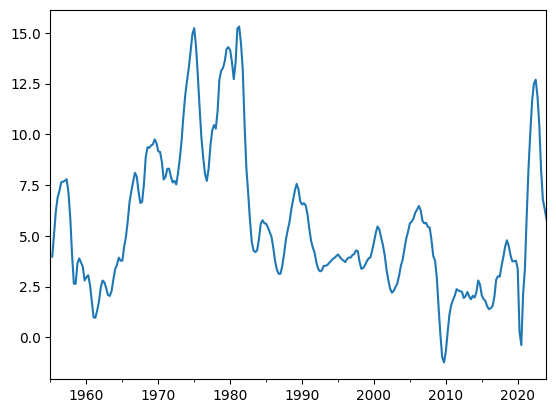

In [1658]:
data['Talyor_Rule'].rolling(2).mean().plot()

In [1659]:
z_train, z_test = temporal_train_test_split(data['Talyor_Rule'], test_size=0.2)

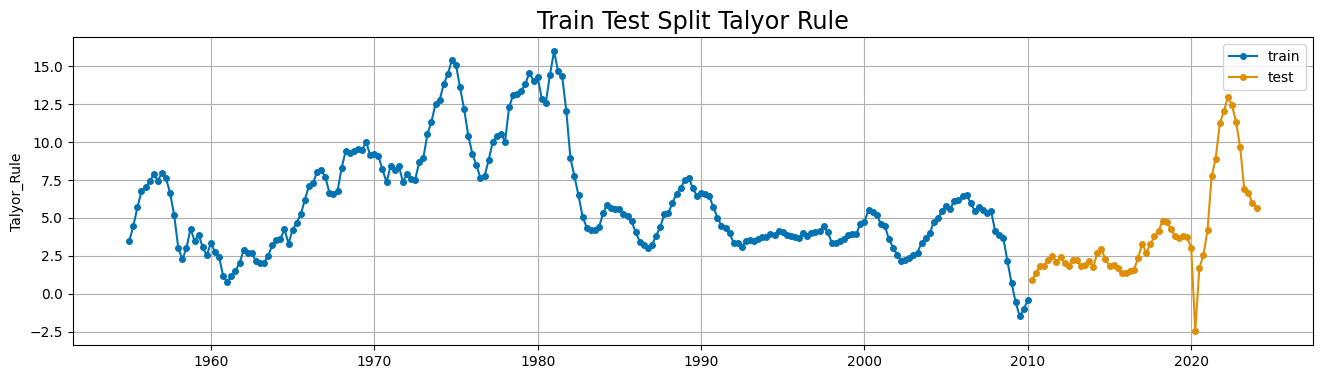

In [1660]:
plot_series(z_train, z_test, labels = ['train', 'test'], title = 'Train Test Split Talyor Rule')
plt.grid();

###Talyor Naive

As done for the fed funds rate, in this report our baseline model will be the naive forecaster using the last value as our main form to compare models.

In [1661]:
from sktime.forecasting.naive import NaiveForecaster
nf = NaiveForecaster(strategy="last")
nf.fit(z_train)

NaiveForecaster()

In [1662]:
fh = np.arange(len(z_test))

In [1663]:
z_preds = nf.predict(fh)

In [1664]:
mae = MeanAbsolutePercentageError()
mae(z_test, z_preds)

/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:645: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


1.1579201426540193

Here we see the naive forecaster has a very high mae, which makes sense as it is just predicting that rates will not change in the future.

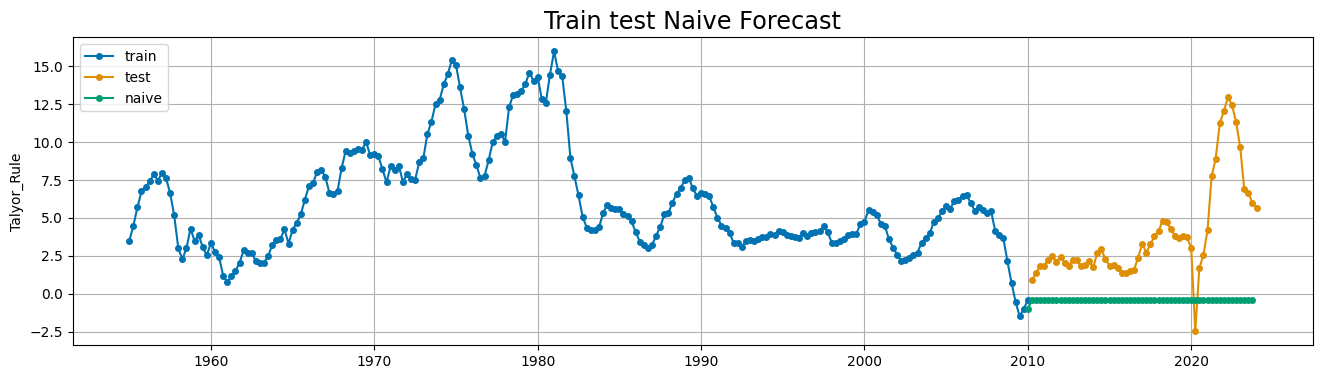

In [1666]:
plot_series(z_train, z_test, z_preds,
            labels = ['train','test','naive'],
             title='Train test Naive Forecast')

plt.grid();

In [1667]:
forecaster = NaiveForecaster(strategy="last")

In [1668]:
forecaster.fit(z)

NaiveForecaster()

In [1669]:
z_hat = forecaster.predict( fh = [i for i in range(0, 16)])

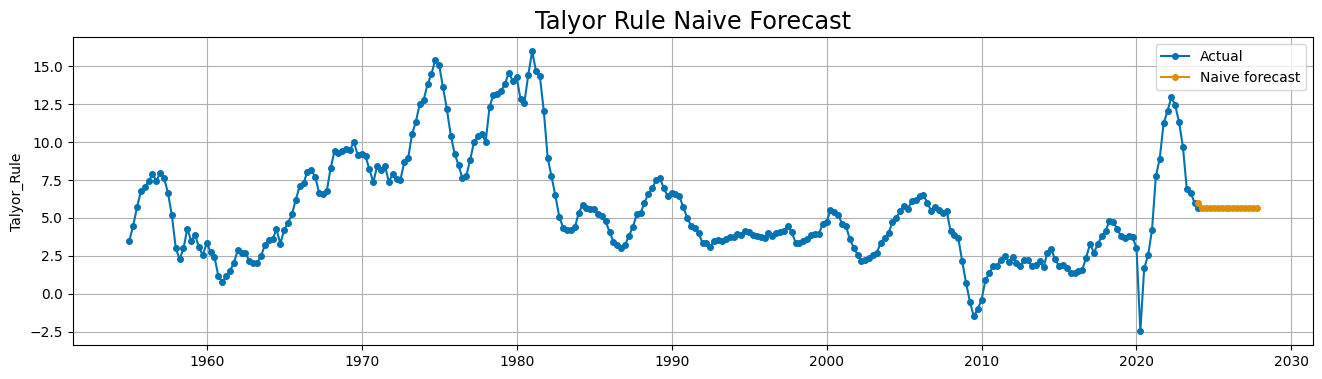

In [1670]:
plot_series(z, z_hat,
            labels=['Actual','Naive forecast'],
            title='Talyor Rule Naive Forecast')
plt.grid();
plt.savefig('naive_forecast.png')

###Talyor Rule: Holt-Winters Model

In [1690]:
hw= ExponentialSmoothing(sp=32, trend='add', seasonal='add')

Due to the talyor rule calling for negative rates in more recent years the multiplicative feature is unable to be done.

In [1691]:
hw.fit(z_train)

ExponentialSmoothing(seasonal='add', sp=32, trend='add')

In [1692]:
fh= np.arange(len(z_test))

In [1693]:
z_hw_predicts= hw.predict(fh)

In [1694]:
mae = MeanAbsolutePercentageError()
mae(z_test, z_hw_predicts)

/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:645: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


1.186993984696811

Here, we see the holt-winters model performs roughly the same as the baseline in terms of mae. Therefore, this model may not be the ideal choice in predicting the upcoming talyor rule metrics.

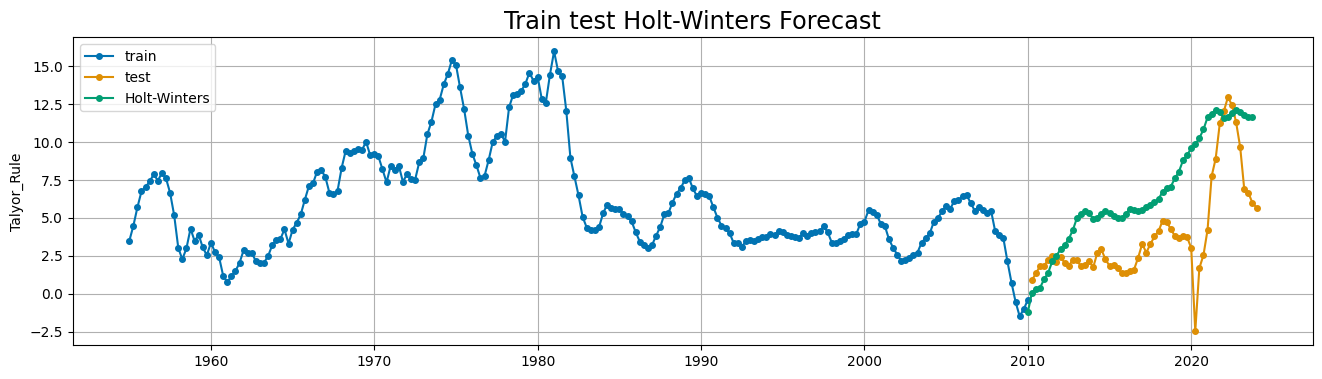

In [1695]:
plot_series(z_train, z_test, z_hw_predicts,
            labels = ['train', 'test','Holt-Winters'],
             title='Train test Holt-Winters Forecast')
plt.grid();


Here we see a lot more movement from the model compared to the last as it is trying to understand and predict the test variables. We can see the model does not do a good job at matching the test data.

In [1696]:
hw.fit(z)

ExponentialSmoothing(seasonal='add', sp=32, trend='add')

In [1697]:
z_hw = hw.predict( fh = [i for i in range(0, 16)])

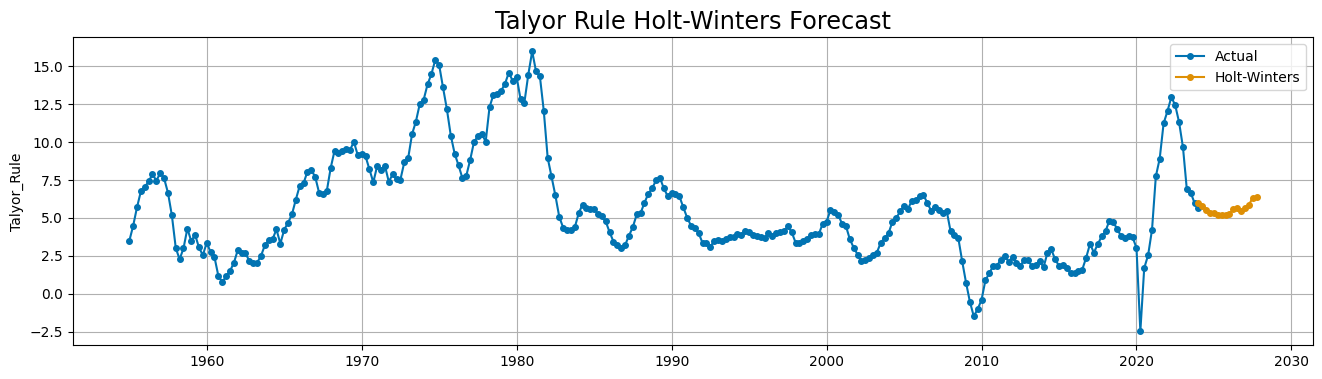

In [1698]:
plot_series(z, z_hw,
            labels=['Actual','Holt-Winters'],
            title='Talyor Rule Holt-Winters Forecast')
plt.grid();
plt.savefig('naive_forecast.png')

This is what the holt-winters model predicts once it was feed all the data. As we can see it predicts that there would be a slight dip in rates following by an increase after.

###Talyor Rule: ARIMA Model

Next we will examine the auto arima model

In [1699]:
auto_model = pm.auto_arima(z_train,
                          seasonal=True, m=8,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=False)

 ARIMA(0,1,0)(0,0,0)[8] intercept   : AIC=495.532, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[8] intercept   : AIC=485.299, Time=1.16 sec
 ARIMA(0,1,0)(0,0,2)[8] intercept   : AIC=486.847, Time=0.62 sec
 ARIMA(0,1,0)(1,0,0)[8] intercept   : AIC=485.334, Time=0.30 sec
 ARIMA(0,1,0)(1,0,1)[8] intercept   : AIC=487.039, Time=2.11 sec
 ARIMA(0,1,0)(1,0,2)[8] intercept   : AIC=488.538, Time=0.78 sec
 ARIMA(0,1,0)(2,0,0)[8] intercept   : AIC=486.831, Time=0.26 sec
 ARIMA(0,1,0)(2,0,1)[8] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,1,0)(2,0,2)[8] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(0,1,1)(0,0,0)[8] intercept   : AIC=458.133, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[8] intercept   : AIC=453.052, Time=0.18 sec
 ARIMA(0,1,1)(0,0,2)[8] intercept   : AIC=454.121, Time=0.69 sec
 ARIMA(0,1,1)(1,0,0)[8] intercept   : AIC=452.463, Time=0.36 sec
 ARIMA(0,1,1)(1,0,1)[8] intercept   : AIC=454.420, Time=0.88 sec
 ARIMA(0,1,1)(1,0,2)[8] intercept   : AIC=456.001, Time=1.27 sec
 ARIMA(0,1,1)(2,0,0)[8] intercept

In [1700]:
arima= ARIMA(order=(0,1,3), seasonal_order=(1,0,0,8))

In [1701]:
arima.fit(z_train)

ARIMA(order=(0, 1, 3), seasonal_order=(1, 0, 0, 8))

In [1702]:
fh= np.arange(len(z_test))

In [1703]:
z_arima_preds = arima.predict(fh)

In [1704]:
mae(z_test, z_arima_preds)

/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:645: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


0.7931110335712804

Here the model performs better than our baseline, although still not very well overall.

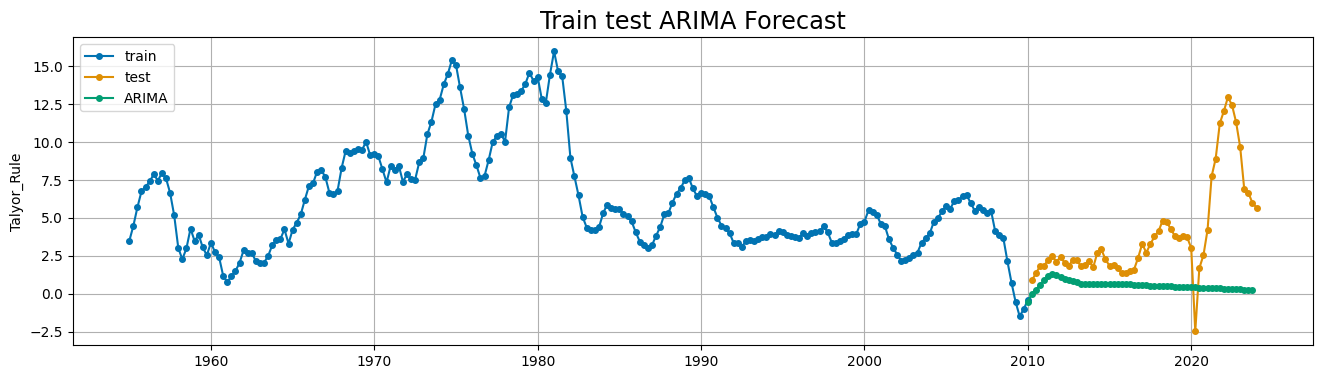

In [1705]:
plot_series(z_train, z_test, z_arima_preds,
            labels = ['train', 'test','ARIMA'],
            title='Train test ARIMA Forecast')

plt.grid();

Here we see intially the mdoel is able to track and follo what the test data did, but it hits a certain point and again flattens out.

In [1710]:
arima.fit(z)

ARIMA(order=(0, 1, 3), seasonal_order=(1, 0, 0, 8))

In [1711]:
fh= np.arange(0, 16)

In [1712]:
z_arima= arima.predict(fh)

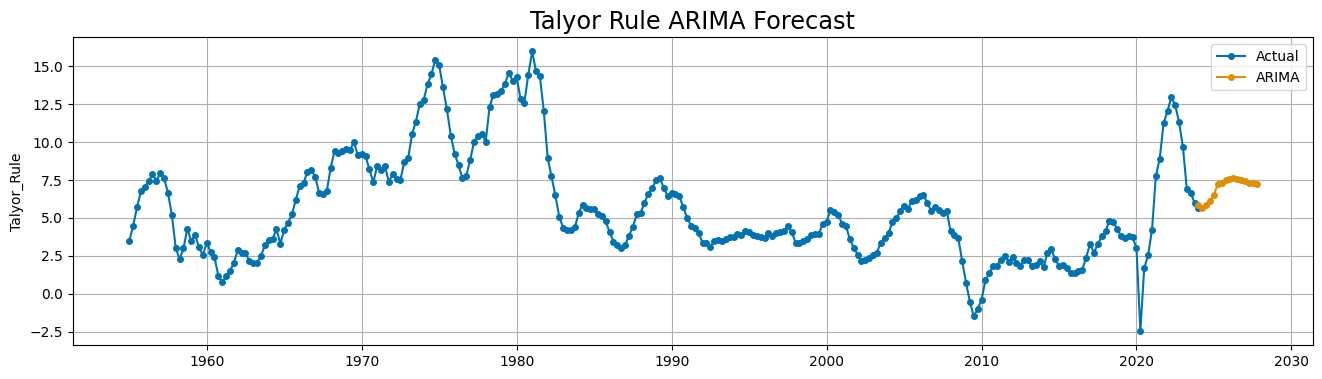

In [1713]:
plot_series(z, z_arima,
            labels = ['Actual','ARIMA'],
            title='Talyor Rule ARIMA Forecast')

plt.grid();

In this instance we see the model predicts that the data will initially decrease and then after some time increase again.

###Taylor Prophet Model

In [1714]:
prophet= Prophet(seasonality_mode='additive', n_changepoints=int(len(z)))

In [1715]:
prophet.fit(z_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 175.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchdf5ucg/mvz0hx6i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchdf5ucg/prnv48em.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35220', 'data', 'file=/tmp/tmpchdf5ucg/mvz0hx6i.json', 'init=/tmp/tmpchdf5ucg/prnv48em.json', 'output', 'file=/tmp/tmpchdf5ucg/prophet_modelwzr_riz5/prophet_model-20241213033255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:32:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:32:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Prophet(n_changepoints=277)

In [1716]:
fh = np.arange(len(z_test))

In [1717]:
z_prophet_preds = prophet.predict(fh)

In [1718]:
mae = MeanAbsolutePercentageError()
mae(z_test, z_prophet_preds)

/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:645: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


0.5923532028405355

Here we see the prophet model is the best in reference to having the lowest mae compared to the other models.

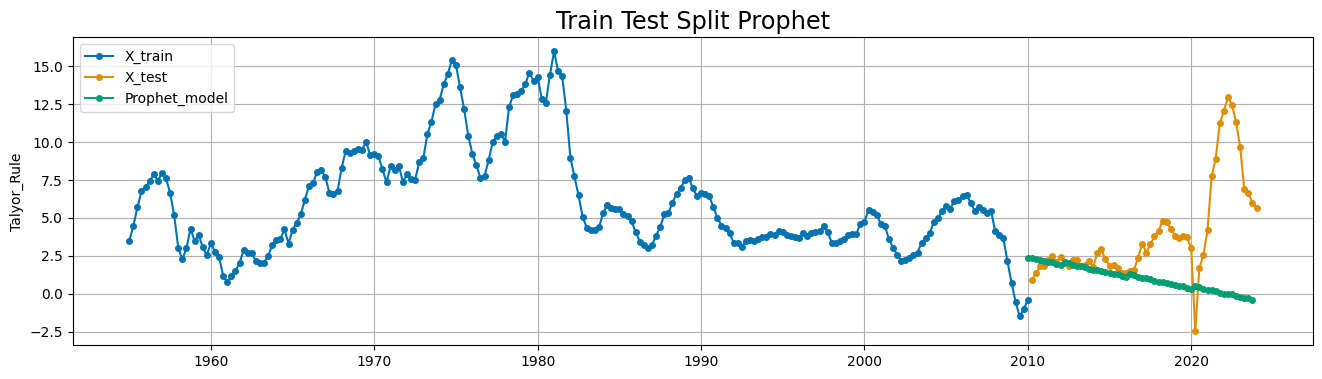

In [1377]:
plot_series(z_train, z_test, z_prophet_preds,
            labels=['X_train', 'X_test','Prophet_model'],
            title='Train Test Split Prophet')
plt.grid();

Here we see the prophet model is able to predict the general downward trend of the taylor rule overtime, although it fails to pick up and match the test data.

In [1719]:
prophet.fit(z)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 220.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchdf5ucg/xk80dnf0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpchdf5ucg/71l_i256.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38077', 'data', 'file=/tmp/tmpchdf5ucg/xk80dnf0.json', 'init=/tmp/tmpchdf5ucg/71l_i256.json', 'output', 'file=/tmp/tmpchdf5ucg/prophet_model_l39z2kc/prophet_model-20241213033415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:34:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:34:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Prophet(n_changepoints=277)

In [1720]:
z_prophet= prophet.predict(fh)

In [1721]:
fh= np.arange(0, 16)

In [1722]:
z_pred= prophet.predict(fh)

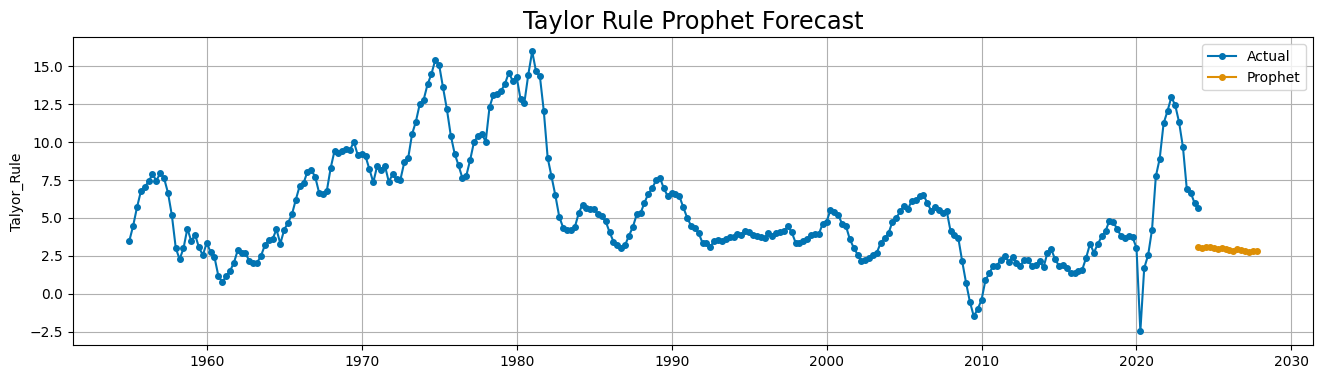

In [1723]:
plot_series(z, z_pred,
            labels=['Actual','Prophet'],
            title='Taylor Rule Prophet Forecast')
plt.grid();

Here we see the model just reflects a general downward trend of the taylor rule in the coming quarters.

###All Talyor Role Predictive Models

In [1726]:
data_mean = X_train.mean()
data_mean

4.94433734939759

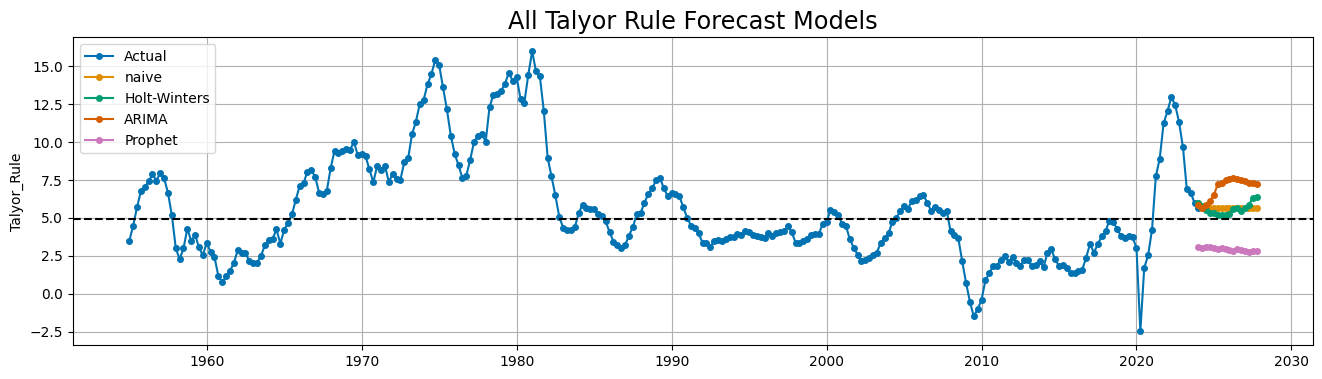

In [1727]:
plot_series(z, z_hat, z_hw, z_arima, z_pred,
            labels = ['Actual', 'naive', 'Holt-Winters','ARIMA', 'Prophet'],
            title='All Talyor Rule Forecast Models'
           )
plt.axhline(y=data_mean, color='black', linestyle='--', label='Mean')
plt.grid();

For the most part all the models initially predict a downward trend in the talyor rule in the coming quarters although they also predict an upward trend after that.

##Taylor Rule Paired with the Fed Funds Rate

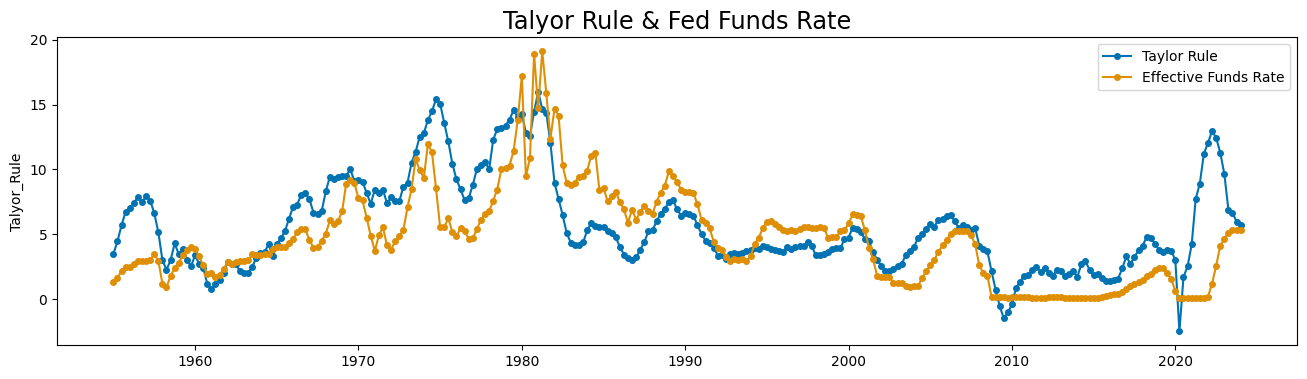

In [1384]:
plot_series(data['Talyor_Rule'], data['FEDFUNDS'], labels=['Taylor Rule', 'Effective Funds Rate'], title='Talyor Rule & Fed Funds Rate');

In this instance, I thought it would be interesting to circle back to the original point made in the beginning of the report. In this report, we are trying to examine the comparison between the Fed funds rate and the taylor rule. We are trying to examine what insight the relationship of each can provide, by modeling predict values for each 4 years in advance and evaluating if there is any overlap.

In this example, we see the historical overlap. Typically, we see the Talyor rule and the fed funds rate move in the same direction. Although at times the Taylor rule moves at a faster pace. For example as the 2001 dot dom bubble we see that the Taylor Rule moves upward in a steeper manner compared to the fed funds rate. This may indicate that the fed was slow to hike rates after the dot com bubble. Another example is after covid the Talyor rule shoots up after a steep decline, indicating that the shock creatded by the pandemic had inflationary characterisics following. The comparison between the two reflects again that the fed may have been slow to act in response to the current economic indicators.

Moving forward lets examine if the Taylor Rule's predictive models move in steeper directions compared to the fed funds rate.

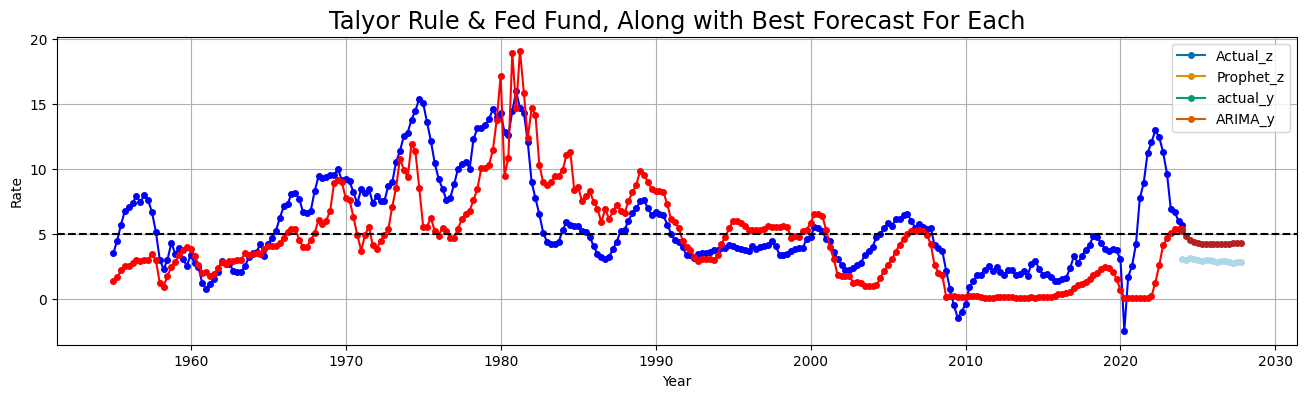

In [1732]:
plot_series(
    z,
    z_pred,
    #z_arima,
    y,
    y_arima,
   # y_hw,
    labels=[
        'Actual_z',
        'Prophet_z',
        #'ARIMA_z',
        'actual_y',
        'ARIMA_y',
        #'Holt-Winters_y',
    ],
    title='Talyor Rule & Fed Fund, Along with Best Forecast For Each',
    y_label= 'Rate',
    x_label='Year'
)
plt.axhline(y=data_mean, color='black', linestyle='--', label='Mean')
plt.grid()

lines = plt.gca().get_lines()
lines[0].set_color('blue')  # Actual_z (Taylor Rule)
lines[1].set_color('lightblue')   # Prophet_z (Talyor Rule)
lines[2].set_color('red') # actual_y (Fed Funds Rate)
lines[3].set_color('firebrick') # ARIMA_y (Fed Funds Rate)


In this graph above we see the best performing models from each the Taylor Rule and the Fed Funds rate. For the Taylor Rule the best performing model was the prophet model compared to the baseline of the naive forecaster that just replciated the fed not making a rate adjustment for the next 4 years. Whereas, with the Fed Funds Rate we saw the best preforming model was the ARIMA model when again compared to the naive forecaster.

Overall, we see a general downward trend in the rates in the coming years. This is also expected as the Fed has already started to cut rates and most recently the central bank of europe cut its rate to 3%. It is interesting to note that each model is relatively flat after an initial decrease. Also the fact that each model preformed poorly in predicting the test variable although it outperformed the baseline. Therefore, take this model with a grain of salt as the fed funds rate and the Taylor rule aren't truly seasonal as holiday deals.

## Next Steps & Discussion

The most accurate models that performed better the baseline maybe could be altered with more to further perfect each model's ability to predict upcoming trends. It seems we are entering a downward rate environment. It will be interesting to see for how long this upcoming trend will last, as with recent policy proposal of tariffs may negatively impact this forecast and revert rates to increase or maintain at the current levels. The recent CPI report of 2.7% could also signify that inflation has yet to go, it will be interesting to see what the Fed does in the next meeting in December if they decide to cut the rates or hold at current levels.

Key Findings
1.) We examined the varying success of different models. For the most part, overall, ARIMA was the best-performing model, factoring in how it performed for both the Fed Funds Rate and also the Talyor Rule. However, when examining individual model performance we saw that the best model for predicting the Fed Funds Rate was the ARIMA model, whereas for the Talyor Rule it was the Prophet model by Facebook.
2.) Overall, we saw the impact that rates have on inflation, GDP, and the duration of the interest rate regimes. It exemplified how interest rates are a powerful tool for tackling inflation, along with its massive impact on economic output, specifically how lower interest rate regimes typically followed economic downturns and vice versa for high interest rate regimes.
3.) Overall it seems very difficult to predict the future of rates as a lot of economic indicators are needed as inputs, solely examining historical changes and adjustments may not be enough.

Future Projects and Improvements
Future projects could examine the economic indicators that influence interest rates such as unemployment, CPI, Real_GDP, and Potential GDP. The model could evaluate how these features interacted with impacted the fed funds rate along with its impact on the Taylor Rule. In doing so one is breaking the Taylor Rule down into its compartmental parts and predicting how changes in those may further impact the models we created. It would be interesting to understand the weights assigned to each and how that may impact the performance of future models. Another interesting factor could be to examine other tools that the fed has as its disposal and how those may alter the fed's decision to cut or hold rates. To further understand the grasp of the tools they have available and when they decide to enact certain monetary policies compared to others.

In reference to improvements in the models in this report one could further fine-tone the hyperparameters of each model. Another aspect could be to apply the Markov regression model to try and predict whether the upcoming interest rate regime will be high or low. Finally, overall, another area of improvement could be to examine specific periods rather than the entire historical trend and train the data based on certain historical periods.